<a href="https://colab.research.google.com/github/linjikai/ai/blob/master/%E5%AE%98%E6%96%B9%E4%BB%A3%E7%A0%81%E6%94%B9%E9%80%A0ResNet50%E5%9B%BE%E5%83%8F%E5%88%86%E7%B1%BB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import numpy as np

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 3s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
print(data_dir)

3670
/root/.keras/datasets/flower_photos


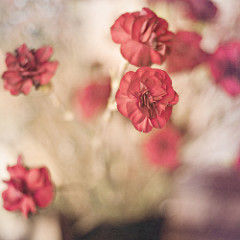

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


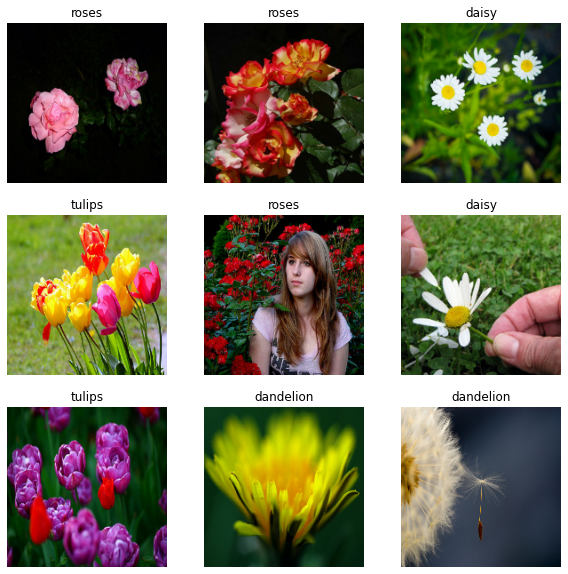

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


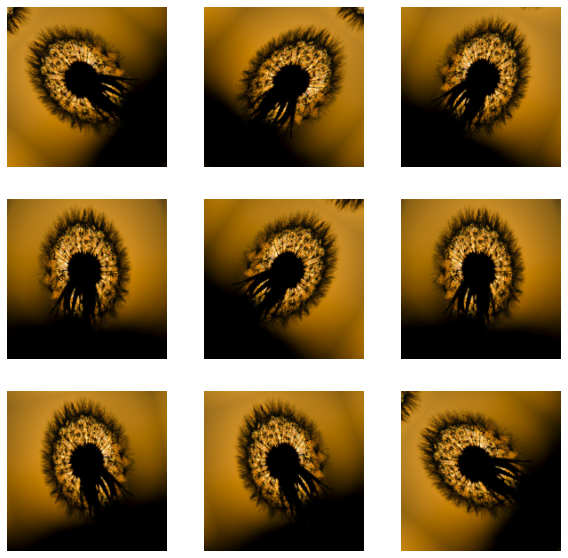

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
base_model = ResNet50(include_top=False, weights='imagenet',input_shape=(180,180,3))

inputs = tf.keras.Input(shape=(180,180,3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x,training=False)
print(base_model.output.shape)
x = GlobalAveragePooling2D()(x)
y = Dense(5, activation='softmax')(x) #final layer with softmax activation
print(y.shape)
model = Model(inputs=inputs, outputs=y, name="ResNet50")
model.summary()

(None, 6, 6, 2048)
(None, 5)
Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 6, 6, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 23,544,837
Non-trainable params: 53,120
____________

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = tf.metrics.SparseCategoricalAccuracy()
model.compile(optimizer='Adam', loss=loss, metrics=metrics)
len(model.trainable_variables)

214

In [15]:
history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds)

Epoch 1/20
92/92 [==============================] - 53s 574ms/step - loss: 0.8830 - sparse_categorical_accuracy: 0.6618 - val_loss: 0.8919 - val_sparse_categorical_accuracy: 0.6444
Epoch 2/20
92/92 [==============================] - 53s 572ms/step - loss: 0.8254 - sparse_categorical_accuracy: 0.6846 - val_loss: 0.9427 - val_sparse_categorical_accuracy: 0.6403
Epoch 3/20
92/92 [==============================] - 53s 572ms/step - loss: 0.8110 - sparse_categorical_accuracy: 0.6962 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.6621
Epoch 4/20
92/92 [==============================] - 52s 571ms/step - loss: 0.7249 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.8234 - val_sparse_categorical_accuracy: 0.6880
Epoch 5/20
92/92 [==============================] - 52s 571ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.9092 - val_sparse_categorical_accuracy: 0.6567
Epoch 6/20
92/92 [==============================] - 52s 570ms/step - loss: 0.6642 - sparse_cate